# Analysis of Resource Ratios

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List
from fractions import Fraction

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [5]:
greedy_name = 'Greedy Utility / Sqrt Sum, Product, Pow percent sum'
algorithms = [('Elastic Greedy Algorithm', greedy_name), ('Non-Elastic Optimal', 'Fixed Optimal')]

ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_labels = ['1:9', '1:4', '3:7', '2:3', '1:1', '3:2', '7:3', '4:1', '9:1']

In [59]:
#results_filename = "../data/old/resource_ratio/resource_ratio_paper_r_t40_s8_dt07-27_00-30-22.json"
results_filename = "../data/old/resource_ratio/resource_ratio_paper_r_t15_s3_dt10-04_00-09-21.json"

with open(results_filename) as file:
    results_data = json.load(file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Algo: Greedy Utility / Sqrt Sum, Product, Pow percent sum - Mean: [431.12 599.24 646.88 651.44 633.2  583.36 500.64 380.52 216.  ], Error: [23.43971728 28.56650721 29.53138081 29.82500875 29.24624756 30.55305034
 29.43434632 23.12550701 11.23666479]
Algo: Fixed Optimal - Mean: [255.32 496.2  646.44 669.44 610.8  526.76 419.6  277.16  82.52], Error: [16.3082252  21.34122309 27.14702994 28.17562931 27.03106484 24.1253705
 22.18927764 19.22948558 23.52995992]
Save file location: figs/eps/resource_ratio_social_welfare.eps
Save file location: figs/png/resource_ratio_social_welfare.png
Save file location: figs/pdf/resource_ratio_social_welfare.pdf


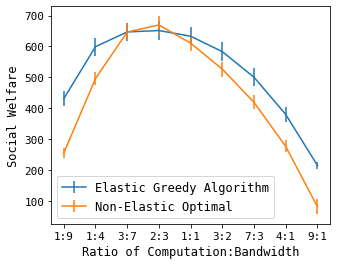

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
for name, algo in algorithms:
    social_welfares = [[model_data[f'ratio {ratio}'][algo]['social welfare'] 
                        for model_data in ratio_resource_data] for ratio in ratios]
    error = 1.96 * np.std(social_welfares, axis=1) / np.sqrt(len(ratio_resource_data))
    ax.errorbar(x=ratios, y=np.mean(social_welfares, axis=1), yerr=error, label=name)

ax.set_ylabel('Social Welfare', fontsize=12)
ax.set_xlabel('Ratio of Computation:Bandwidth', fontsize=12)

plt.legend(fontsize=12)
save_plot('resource_ratio_social_welfare')

## Resource ratio social welfare percentage average

In [13]:
for ratio in ratios:
    difference = round(np.mean([r[f'ratio {ratio}'][greedy_name]['social welfare percent'] - 
                                r[f'ratio {ratio}']['Fixed Optimal']['social welfare percent']
                                for r in results_data]), 3)
    print(f'Ratio: {ratio}, difference: {difference}')

Ratio: 0.1, difference: 0.234
Ratio: 0.2, difference: 0.136
Ratio: 0.3, difference: 0.0
Ratio: 0.4, difference: -0.024
Ratio: 0.5, difference: 0.03
Ratio: 0.6, difference: 0.075
Ratio: 0.7, difference: 0.107
Ratio: 0.8, difference: 0.137
Ratio: 0.9, difference: 0.177


### Resource ratio server resource usage

Algo: Elastic Greedy Algorithm - Mean: [0.47232561 0.72738482 0.8074663  0.81898173 0.78310848 0.69458522
 0.5728521  0.41079365 0.20909224], Error: [0.05213805 0.06643263 0.05769511 0.05410211 0.05732683 0.06627343
 0.06667158 0.04552223 0.01825475]
Algo: Non-Elastic Optimal - Mean: [0.26456859 0.57881903 0.83235037 0.87251549 0.77512298 0.62781886
 0.47298215 0.27933548 0.09293755], Error: [0.03642834 0.05545448 0.04883337 0.04185669 0.05326969 0.05868547
 0.04383514 0.03722474 0.04160253]
Algo: Elastic Greedy Algorithm - Mean: [0.68516136 1.37791012 1.98462932 2.50242845 3.1161094  3.23396401
 3.6927671  3.51636297 2.58006843], Error: [0.36510917 0.76678062 1.10342385 1.37047674 1.81093429 1.45746675
 2.35750168 2.02346498 1.40291397]
Algo: Non-Elastic Optimal - Mean: [0.64263454 1.44473709 2.23365178 2.3939247  2.04443967 1.57309436
 1.19252729 0.68809033 0.13404717], Error: [0.36429388 0.70227583 1.17027893 1.29240854 1.11111068 0.76348594
 0.64413638 0.36130838 0.06563349]
Algo: 

<ipython-input-68-f971517f62ee>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratio_labels)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/png/resource_ratio_server_resource_usage.png
Save file location: figs/pdf/resource_ratio_server_resource_usage.pdf


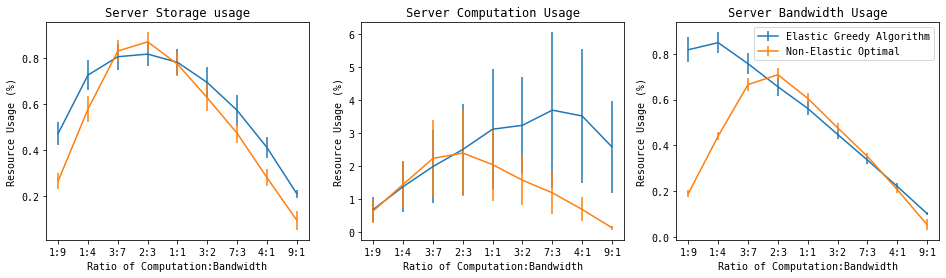

In [68]:
flatten = lambda t: [item for sublist in t for item in sublist]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for ax, resource in zip(axs, ['server storage usage', 'server compute usage', 'server bandwidth usage']):
    ax.set_title(resource.title())
    for name, algo in algorithms:
        ratio_results = [flatten([list(model_data[f'ratio {ratio}'][algo][resource].values()) 
                                  for model_data in ratio_resource_data]) for ratio in ratios]
        ax.errorbar(ratios, np.mean(ratio_results, axis=1), 
                    yerr=1.96 * np.std(ratio_results, axis=1) / np.sqrt(len(ratio_resource_data)), label=name)
        
    ax.set_xticks(ratios)
    ax.set_xticklabels([str(ratio) for ratio in ratios])
    ax.set_xlabel('Ratio of Computation:Bandwidth')
    ax.set_ylabel('Resource Usage (%)')

plt.legend()
save_plot('resource_ratio_server_usage')

## Resource ratio social welfare difference

In [ ]:
diff_fig, diff_ax = plt.subplots(figsize=(7, 6))

differences = [
    [result[f'ratio {ratio}'][greedy_name]['social welfare'] - 
     result[f'ratio {ratio}'][fixed_greedy_name]['social welfare']
     for result in results_data]
    for ratio in ratios
]

diff_ax.boxplot(differences, widths=0.8)
diff_ax.set_ylabel('Difference in Social Welfare')
plt.xticks(ticks=np.arange(len(ratios)+1), labels=['', '1:10', '1:5', '3:7', '2:3', '1:1', '5:2', '7:3', '5:1', '10:1'])
diff_ax.set_xlabel('Ratio of Computation:Bandwidth')
save_plot('social_welfare_difference', 'resource_ratio')